In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')
import important_functionalities as impf

2025-03-13 19:13:05.120814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**2.3. Running a model experiment using 1% of training data**

Data: https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

In [2]:
# load data
data_dir='10_food_classes_1_percent'
train_dir=data_dir+'/train'
valid_dir=data_dir+'/test'

impf.walkthrough_directories(data_dir)

There are 2 directories and 0 images in 10_food_classes_1_percent
There are 10 directories and 0 images in 10_food_classes_1_percent/test
There are 0 directories and 250 images in 10_food_classes_1_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_1_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_1_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_1_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_1_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_1_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_1_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_1_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_1_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_1_percent/test/chicken_curry
There are 10 directories and 0 ima

In [3]:
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                               image_size=IMAGE_SHAPE,
                                                               label_mode='categorical',
                                                                batch_size=BATCH_SIZE
                                                               )
valid_data=tf.keras.preprocessing.image_dataset_from_directory(directory=valid_dir,
                                                               image_size=IMAGE_SHAPE,
                                                                label_mode='categorical',
                                                                 batch_size=BATCH_SIZE
                                                                )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


| Experiment | Data       | Preprocessing | Model          |
|------------|------------|---------------|----------------|
| Model 1     | 10 classes of food101 dataset (random 1% training data only)  | Random flip, Rotation, Height, Width data-augmentation       | Same as Model 0|

**Adding data augmentation right into the model**
<br>
*To add data augmentation into our models, we can use the layers inside: `tf.keras.layers.Data_Augmentation_Methods()`
* Advantages:
  * Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
  * Image Data Augmentation only happens during training and are turned off during inference (doesn't augment testing data or new unseen data), we can still export our whole model and use it elsewhere.

In [4]:
# Creating Model 1

### 1. Create data augmentation stage with horizontal flipping, rotations, zooms etc

### We can create a layer for our functional API models using Sequential API
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.experimental.preprocessing.Rescaling(1./255)# keep for models like ResNet50V2 but EfficientNet has rescaling built-in,
],name='data_augmentation')

(224, 224, 3)
(1, 221, 219, 3)


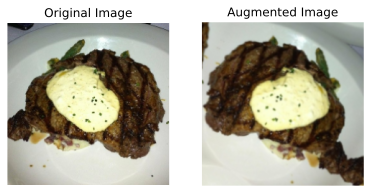

In [5]:

# visualize data augmentation layer (using random image from training dataset)
import random
import os

target_class=random.choice(train_data.class_names)
target_dir=train_dir+'/'+target_class

random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+'/'+random_image

img=tf.io.read_file(random_image_path)
img=tf.image.decode_image(img)
img=tf.image.resize(img,size=IMAGE_SHAPE)
print(img.shape)
fig,ax=plt.subplots(1,2)
ax[0].imshow(img/255.0)
ax[0].set_title('Original Image')
ax[0].axis('off')

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
print(augmented_img.shape)
ax[1].imshow(tf.squeeze(augmented_img)/255.)
ax[1].set_title('Augmented Image')
ax[1].axis('off')
plt.show()

In [6]:
input_shape=(224,224,3)
### 2. Create the base model with tf.keras.applications
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False,#exclude o/p layer
                                                                  weights='imagenet',
                                                                 input_shape=input_shape) 

### 3. Freeze the layers in the base model
base_model.trainable=False

### 4. Create inputs into our model
inputs = tf.keras.layers.Input(shape=input_shape,name='input_layer')    
print(f"Shape of inputs: {inputs.shape}")
### 5. Adding data augmentation sequential layer model as a layer
x=data_augmentation(inputs,training=True)
print(f"Shape after data_augmentation: {x.shape}") 

### 6. Pass the inputs to the base_model
x = base_model(x)
print(f"Shape after base_model: {x.shape}")

### 7. max pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_max_pooling_layer')(x)
print(f"After GlobalmaxPooling2D(): {x.shape}")

### 8. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

### 9. Combine the inputs with the outputs into a model
model_1=tf.keras.Model(inputs,outputs)


### 10. Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### 11. Fit the model and save its history
history_1_percent=model_1.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data),
                               validation_data=valid_data,
                               validation_steps=int(0.25*len(valid_data)),
                               callbacks=[impf.create_tensorboard_callback(dir_name="transfer_learning",     experiment_name="1_percent_feature_extraction")])

Shape of inputs: (None, 224, 224, 3)
Shape after data_augmentation: (None, None, None, 3)
Shape after base_model: (None, None, None, 1280)
After GlobalmaxPooling2D(): (None, 1280)
Saving TensorBoard log files to : transfer_learning/1_percent_feature_extraction/20250313-191344
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.1795 - loss: 2.3035 - val_accuracy: 0.2878 - val_loss: 2.1093
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.2646 - loss: 2.1110 - val_accuracy: 0.3322 - val_loss: 2.0118
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.5598 - loss: 1.9056 - val_accuracy: 0.3717 - val_loss: 1.9173
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.5117 - loss: 1.8215 - val_accuracy: 0.4161 - val_loss: 1.8372
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.6151 - loss: 1.6422 - val_accuracy: 0.4309 - val_loss: 1.7707


In [7]:
# check out model summary
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_layer        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [8]:
results_1_percent_data_aug=model_1.evaluate(valid_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 659ms/step - accuracy: 0.4481 - loss: 1.7523


[1.756181001663208, 0.45719999074935913]

<Figure size 640x480 with 0 Axes>

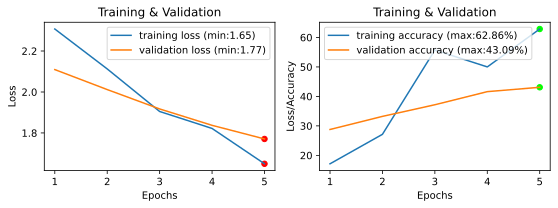

In [9]:
impf.plot_loss_curves(history_1_percent)

***-- CONTD IN NEXT NOTEBOOK --***